# ソーシャルネットワーク分析

## Pajekファイルの読み込み

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import re
import itertools

from numba import jit


class UnexpectedParameter(Exception):
    pass


### ネットワーク構築用 ###
    
# .pajファイルの読み込み
@jit
def read_pajek_file(file: str, encoding='utf8'):

    paj = ''  # Pajekファイルの読み込み用
    partition = []  # パーティション（開発者かバグIDか）のデータ格納用
    text = True  # 読み込むテキストが存在を判断
    flag = 0  # ノード情報，ノードの属性情報の判断用
    
    f = open(file, encoding=encoding, errors='ignore')
    while text:
        l = f.readline()

        if '*Network' in l:
            pass

        elif '*Vertices' in l:
            if flag == 0:
                num = re.findall(r'[0-9]+', l)
                if len(num) >= 2:
                    l = re.sub(num[-1], '', l)
            elif flag == 1:    
                continue

        elif '*Partition' in l:
            flag = 1
            continue

        if l:
            if flag == 0:
                paj += l
            elif flag == 1:
                l = re.sub('\n', '', l)
                if l == '1':
                    color = 'yellow'
                elif l == '2':
                    color = 'blue'
                else:
                    color = 'red'

                partition.append(color)

        else:
            text = False

    f.close()
    return nx.parse_pajek(paj), partition


# 2-modeから1-modeへネットワークの変換
def to_mode_1_net(node: list, edge: list, partition: list, target: list):

    nodes = node
    edges = pd.DataFrame(edge, columns = ['target', 'source', 'other'])
    edges.drop(columns = ['other'], inplace = True)

    dev = []  # 開発者情報の格納用
    dev_edge = []  # 開発者の繋がり
    dev_net = []  # 開発者のノード，エッジ情報の格納用
    bug_id = []  # バグID情報の格納用
    bug_id_edge = []  # バグIDの繋がり
    bug_id_net = []  # バグIDのノード，エッジ情報の格納用

    #　開発者，バグ報告書にノードを分割
    [dev.append(nodes[i]) if partition[i] == 'yellow' else bug_id.append(nodes[i]) for i in range(len(partition))]

    if 'dev' in target:
        #　開発者ネットワーク構築のためのエッジ抽出
        for i in range(len(bug_id)):
            # 各バグIDに紐づいている開発者を抽出
            b_id = bug_id[i]
            bug_in_edge = edges.query('@b_id == target or @b_id == source')
            bug_in_edge = bug_in_edge['target'].tolist()
            dev_link = set(bug_in_edge) - set(b_id)
            # バグIDに紐づいていた開発者同士でエッジを結ぶ
            dev_edge.extend(itertools.product(dev_link, dev_link))
            # 使用したバグIDは取り除く
            edges = edges.query('@b_id != target or @b_id != source')

    if 'bug' in target:
        #　バグ報告書ネットワーク構築のためのエッジ抽出
        for i in range(len(dev)):
            # 各開発者に紐づいているバグIDを抽出
            d = dev[i]
            dev_in_edge = edges.query('@d == target or @d == source')
            dev_in_edge = dev_in_edge['source'].tolist()
            bug_link = set(dev_in_edge) - set(d)
            # 開発者に紐づいていたバグID同士でエッジを結ぶ
            bug_id_edge.extend(itertools.product(bug_link, bug_link))
            # 使用した開発者は取り除く
            edges = edges.query('@d != target or @d != source')

    if 'dev' in target:
        dev_net = [dev, dev_edge]
        return dev_net

    elif 'bug' in target:
        bug_id_net = [bug_id, bug_id_edge]
        return bug_id_net

    elif 'dev' in target and 'bug' in target:
        dev_net = [dev, dev_edge]
        bug_id_net = [bug_id, bug_id_edge]
        return dev_net, bug_id_net

    
# 時系列分析用関数
@jit
def color_add_node(ori: list, pre: list, post: list):

    '''
    時間（t）におけるノードの集合をpre，時間（t+1）におけるノードの集合ををpostとしている
    oriはtとt+1それぞれにおけるノードの集合を合わせたもの
    変わらずに存在するノード：yellow
    新しく加わったノード：red
    次の時間でなくなったノード：blue
    '''
    
    node_color = []
    
    for i in range(len(ori)):
        if ori[i] in pre and ori[i] in post:
            node_color.append('yellow')

        elif not(ori[i] in pre) and ori[i] in post:
            node_color.append('red')
            
        elif ori[i] in pre and not(ori[i] in post):
            node_color.append('blue')

    return node_color


# ネットワークグラフの出力
def print_net(files: list, target=[], figure_x=50, figure_y=50,
              node_alpha=0.6, edge_alpha=0.8, label_alpha=0.8,
              font_size=10, degree=False, close=False, between=False,
              eigen=False, sequence=False, cluster=False):

    '''
    files：.pajの拡張子のファイルリスト（読み込みたいファイルが1つでもリスト形式で）
    target：1-modeネットワークを構築したいときに使う
            dev：開発者のネットワーク
            bug：バグIDのネットワーク
    figure_x：プロットの横幅
    figure_y：プロットの縦幅
    node_alpha：ノードの濃さ（0 ~ 1）
    edge_alpha：エッジの濃さ（0 ~ 1）
    label_alpha：ラベルの濃さ（0 ~ 1）
    font_size：文字の大きさ
    degree：次数中心性のプロットを行うか（default：False）
    close：近接中心性のプロットを行うか（default：False）
    between:：媒介中心性のプロットを行うか（default：False）
    eigen：固有ベクトル中心性のプロットを行うか（default：False）＊これはいらなさそう
    sequence：時系列分析（default：False）
    cluster：クラスター係数の出力（default：False）
    '''
    
    nodes = []
    edges = []

    for i in range(len(files)):

        G, partition = read_pajek_file(files[i])

        node = list(G.nodes)
        edge = list(G.edges)

        if target:
            if 'dev' == target[0] and len(target) == 1:
                dev_net = to_mode_1_net(node, edge, partition, target)
                nodes.append(dev_net[0])
                edges.append(dev_net[1])

            elif 'bug' == target[0] and len(target) == 1:
                bug_net = to_mode_1_net(node, edge, partition, target)
                nodes.append(bug_net[0])
                edges.append(bug_net[1])

            else:
                raise UnexpectedParameter("target is expected only using a string, either 'dev' or 'bug'.")

        else:
            plt.figure(figsize=(figure_x, figure_y))
            pos = nx.kamada_kawai_layout(G)

            nx.draw_networkx_nodes(G, pos, node_color=partition, alpha=node_alpha)
            nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=edge_alpha)

            nx.draw_networkx_labels(G, pos, font_size=font_size, alpha=label_alpha)

            plt.show()
            plt.close()

    if target:
        if sequence and len(files) > 2:
            count = len(files) - 1
            
            for i in range(count):
                Graph = nx.Graph()

                Graph.add_edges_from(edges[i])
                Graph.add_edges_from(edges[i+1])

                plt.figure(figsize=(figure_x, figure_y))
                pos = nx.kamada_kawai_layout(Graph)

                nx.draw_networkx_nodes(Graph, pos, node_color=color_add_node(list(Graph.nodes), nodes[i], nodes[i+1]), alpha=node_alpha)
                nx.draw_networkx_edges(Graph, pos, edge_color='gray', alpha=edge_alpha)

                nx.draw_networkx_labels(Graph, pos, font_size=font_size, alpha=label_alpha)

        elif not(sequence) or len(files) == 1:

            for i in range(len(files)):
                Graph = nx.Graph()
        
                Graph.add_edges_from(edges[i])
            
                plt.figure(figsize=(figure_x, figure_y))
                pos = nx.kamada_kawai_layout(Graph)

                nx.draw_networkx_nodes(Graph, pos, node_color='yellow', alpha=node_alpha)
                nx.draw_networkx_edges(Graph, pos, edge_color='gray', alpha=edge_alpha)

                nx.draw_networkx_labels(Graph, pos, font_size=font_size, alpha=label_alpha)
                
        plt.show()
        plt.close()
            
        if degree:
            degree_centrality(Graph)
            
        if close:
            close_centrality(Graph)
            
        if between:
            between_centrality(Graph)
            
        if eigen:
            eigen_centrality(Graph)
            
        if cluster:
            print_clustering_value(Graph)
            
            


### 中心性計算用 ###

'''
Graph：グラフオブジェクトを突っ込んでちょーだい
top：上位何件を抽出するのか
'''
        
# 次数中心性
def degree_centrality(Graph: object, top=10):
    
    degree_centers = nx.degree_centrality(Graph)
    degree_centers_sorted =  sorted(degree_centers.items(), key=lambda x: x[1], reverse=True)[:top]
    degree_centers_df = pd.DataFrame(degree_centers_sorted, columns = ['Nodes', 'Degree_Centrality'])
    degree_centers_df.plot(kind='bar')

    
# 近接中心性
def close_centrality(Graph: object, top=10):

    close_centers = nx.closeness_centrality(Graph)
    close_centers_sorted = sorted(close_centers.items(), key=lambda x: x[1], reverse=True)[:top]
    close_centers_df = pd.DataFrame(close_centers_sorted, columns = ['Nodes', 'Close_Centrality'])
    close_centers_df.plot(kind='bar')

    
# 媒介中心性
def between_centrality(Graph: object, top=10):
    
    between_centers = nx.betweenness_centrality(Graph)
    between_centers_sorted = sorted(between_centers.items(), key=lambda x: x[1], reverse=True)[:top]
    between_centers_df = pd.DataFrame(between_centers_sorted, columns = ['Nodes', 'Between_Centrality'])
    between_centers_df.plot(kind='bar')

    
# 固有ベクトル中心性
def eigen_centrality(Graph: object, top=10):
    
    eigen_centers = nx.eigenvector_centrality_numpy(Graph)
    eigen_centers_sorted = sorted(eigen_centers.items(), key=lambda x: x[1], reverse=True)[:top]
    eigen_centers_df = pd.DataFrame(eigen_centers_sorted, columns = ['Nodes', 'Eigen_Centrality'])
    eigen_centers_df.plot(kind='bar')

    
# クラスター係数
def print_clustering_value(Graph: object):
    print('クラスター係数：{}'.format(nx.average_clustering(Graph)))

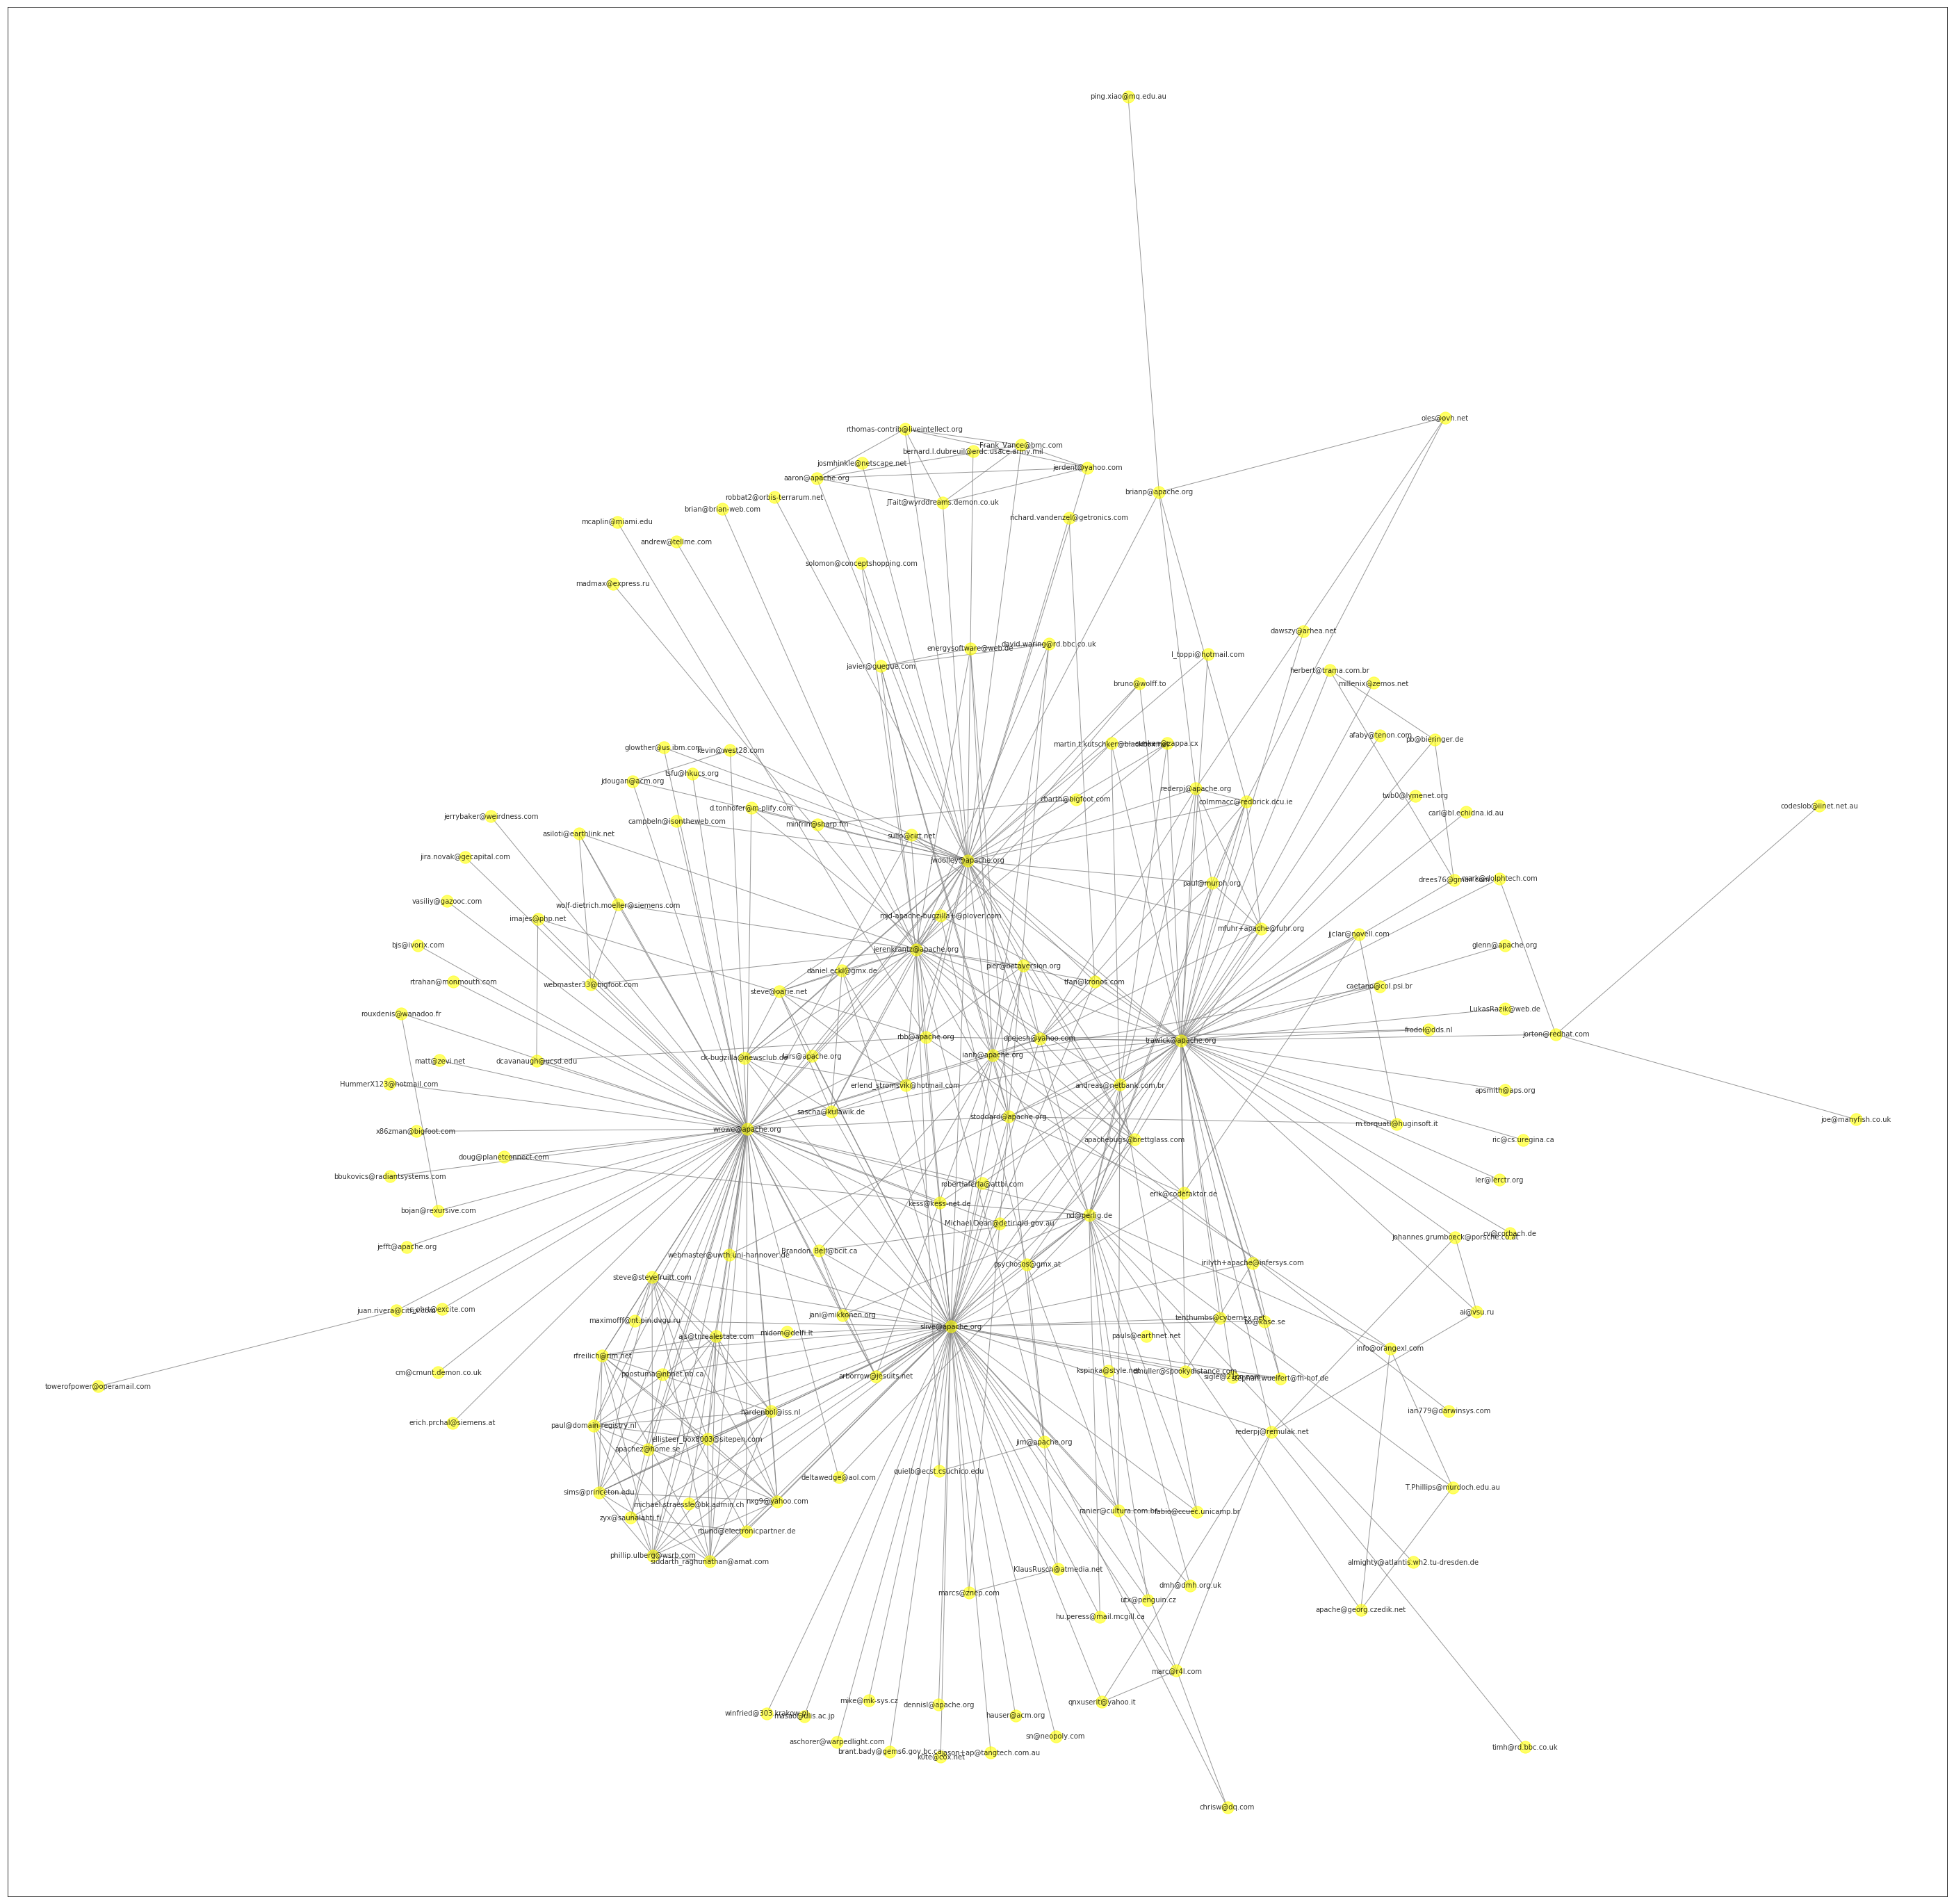

NameError: name 'G' is not defined

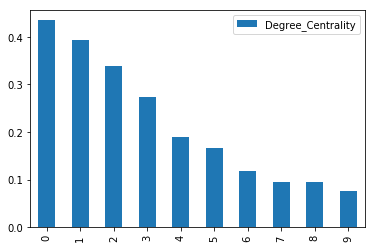

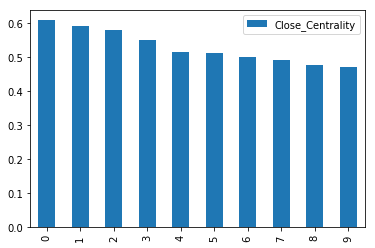

In [2]:
files = ['AnalysisData/2003_1-4/200301.paj']

print_net(files, target=['dev'], degree=True, close=True, between=True, sequence=True)